In [1]:
import pandas as pd
import numpy as np
import annoy
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import keras
from keras.layers import Dense, Dropout, Flatten
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from PIL import Image
import os
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.applications.xception import Xception,preprocess_input
from keras.preprocessing import image
from keras.layers import Input
from keras.backend import reshape
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten,Reshape,UpSampling2D,Input,Lambda,Conv2DTranspose

In [ ]:
transactions=pd.read_csv('transactions_train.csv')
print(transactions.shape)

In [2]:
articles=pd.read_csv('articles.csv')
print(articles.shape)

(105542, 25)


In [4]:
cust=pd.read_csv('customers.csv')

In [5]:
cust.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [3]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [3]:
article_data=pd.read_csv('articles_img_present.csv')
article_data.head()
ids=article_data['article_id']

In [4]:
len(ids)

105099

In [5]:
images=pd.read_csv('img_pres.csv')

In [6]:
images=images.drop('Unnamed: 0',axis=1)
images.rename(columns={'0':'img_id'},inplace=True)
print(images.shape)
images.head()

(105100, 1)


,img_id
0,0108775015.jpg
1,0108775044.jpg
2,0108775051.jpg
3,0110065001.jpg
4,0110065002.jpg


In [7]:
images['path']=images['img_id'].apply(lambda x: f"images/{x[0:3]}/{x}")

In [8]:
images.head()

,img_id,path
0,0108775015.jpg,images/010/0108775015.jpg
1,0108775044.jpg,images/010/0108775044.jpg
2,0108775051.jpg,images/010/0108775051.jpg
3,0110065001.jpg,images/011/0110065001.jpg
4,0110065002.jpg,images/011/0110065002.jpg


In [9]:
ids=ids[0:5000]

In [10]:
ids

0       108775044
1       108775051
2       110065001
3       110065002
4       110065011
          ...    
4995    489435012
4996    489435014
4997    489435015
4998    489435016
4999    489436001
Name: article_id, Length: 5000, dtype: int64

In [11]:
articles=articles.loc[articles['article_id'].isin(ids)][['article_id','product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc']]
articles.shape

(5000, 25)

In [12]:
item_10=pd.DataFrame(articles.product_type_name.value_counts())

In [13]:
item_10[item_10.product_type_name>50].index

Index(['Trousers', 'Socks', 'T-shirt', 'Underwear bottom', 'Shorts',
       'Underwear Tights', 'Vest top', 'Sweater', 'Dress', 'Leggings/Tights',
       'Hoodie', 'Pyjama set', 'Top', 'Bra', 'Pyjama jumpsuit/playsuit',
       'Bodysuit', 'Sunglasses', 'Jacket', 'Shirt', 'Swimwear bottom',
       'Other accessories', 'Hat/beanie', 'Bag', 'Polo shirt', 'Scarf',
       'Belt'],
      dtype='object')

In [14]:
articles_selected=articles[articles.product_type_name.isin(item_10[item_10.product_type_name>50].index)]

In [15]:
embeds=pd.read_csv('similarities.csv')
print(embeds.shape)
embeds.head()

(5000, 5001)


,path,images/010/0108775015.jpg,images/010/0108775044.jpg,images/010/0108775051.jpg,images/011/0110065001.jpg,images/011/0110065002.jpg,images/011/0110065011.jpg,images/011/0111565001.jpg,images/011/0111565003.jpg,images/011/0111586001.jpg,...,images/048/0489217007.jpg,images/048/0489435001.jpg,images/048/0489435002.jpg,images/048/0489435009.jpg,images/048/0489435010.jpg,images/048/0489435011.jpg,images/048/0489435012.jpg,images/048/0489435014.jpg,images/048/0489435015.jpg,images/048/0489435016.jpg
0,images/010/0108775015.jpg,1.000000,0.961681,0.974386,0.977738,0.961188,0.972273,0.941894,0.957899,0.956268,...,0.911624,0.951709,0.951384,0.954769,0.954861,0.950637,0.955816,0.947313,0.954170,0.945386
1,images/010/0108775044.jpg,0.961681,1.000000,0.978197,0.958795,0.993788,0.981855,0.962285,0.958465,0.963825,...,0.918834,0.980947,0.973577,0.976915,0.974529,0.977722,0.975748,0.953639,0.976721,0.961853
2,images/010/0108775051.jpg,0.974386,0.978197,1.000000,0.965839,0.975869,0.977835,0.948924,0.966358,0.962569,...,0.924103,0.970994,0.963249,0.966562,0.967037,0.969613,0.966992,0.957639,0.967525,0.961195
3,images/011/0110065001.jpg,0.977738,0.958795,0.965839,1.000000,0.966312,0.983325,0.943709,0.943825,0.946089,...,0.913624,0.958085,0.963144,0.962034,0.963686,0.957867,0.963485,0.949646,0.962482,0.949798
4,images/011/0110065002.jpg,0.961188,0.993788,0.975869,0.966312,1.000000,0.988004,0.962125,0.951366,0.954847,...,0.913356,0.986873,0.980306,0.981371,0.980496,0.983150,0.981786,0.955436,0.981588,0.965257


In [16]:
embeds.set_index('path',inplace=True)

In [17]:
articles.reset_index(drop=True,inplace=True)

In [18]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
3,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065011,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,12,Light Beige,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [19]:
images

,img_id,path
0,0108775015.jpg,images/010/0108775015.jpg
1,0108775044.jpg,images/010/0108775044.jpg
2,0108775051.jpg,images/010/0108775051.jpg
3,0110065001.jpg,images/011/0110065001.jpg
4,0110065002.jpg,images/011/0110065002.jpg
...,...,...
105095,0953450001.jpg,images/095/0953450001.jpg
105096,0953763001.jpg,images/095/0953763001.jpg
105097,0956217002.jpg,images/095/0956217002.jpg
105098,0957375001.jpg,images/095/0957375001.jpg


In [20]:
item_id=list(articles_selected.article_id)

In [21]:
len(item_id)

4253

In [22]:
accuracy_list={}
for i in item_id:
    given_img=images.loc[images['img_id']=='0'+str(i)+'.jpg']['path'].item()
    given_id=images[images['path']==given_img]['img_id'][:].values[-1][0:10]
    closest_imgs = embeds[given_img].sort_values(ascending=False)[1:5+1].index.values
    aa=[]
    for j in closest_imgs:
        aa.append(images[images['path']==j]['img_id'][:].values[-1])
    y = []
    for k in range(len(aa)):
        y.append(int(aa[k][0:10]))
    b=articles[articles.article_id.isin(y)]['product_type_name'].values
    a=articles[articles.article_id==int(given_id)]['product_type_name'].values
    print(a)
    print(b)
    j=0
    for z in b:
        if(a==z):
            j=j+1 
        print(j/5*100)
    accuracy_list[given_id]=(j/5*100)
print(accuracy_list)

['Vest top']
['Leggings/Tights' 'Vest top' 'Vest top' 'Vest top' 'T-shirt']
0.0
20.0
40.0
60.0
60.0
['Vest top']
['Vest top' 'Vest top' 'Vest top' 'Night gown' 'Jumpsuit/Playsuit']
20.0
40.0
60.0
60.0
60.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'T-shirt' 'Bra' 'Bra' 'Bra']
20.0
20.0
40.0
60.0
80.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Underwear Tights']
['Unknown' 'Underwear Tights' 'Socks' 'Bodysuit' 'Hat/brim']
0.0
20.0
20.0
20.0
20.0
['Socks']
['Leggings/Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
0.0
0.0
0.0
0.0
0.0
['Leggings/Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Leggings/Tights' 'Underwear Tights']
0.0
0.0
0.0
20.0
20.0
['Underwear Tights']
['Leggings/Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
0.0
20.0
40.0
60.0
80.0
['Underwear Tights']
['Underwear Tights' 'Leggings/Tights' 'Leggings/Tights' 'U

['Pyjama jumpsuit/playsuit']
['Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jumpsuit/playsuit' 'Pyjama set' 'Shirt']
20.0
40.0
60.0
60.0
60.0
['Pyjama jumpsuit/playsuit']
['Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jumpsuit/playsuit']
20.0
40.0
60.0
80.0
100.0
['Pyjama jumpsuit/playsuit']
['Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jumpsuit/playsuit']
20.0
40.0
60.0
80.0
100.0
['Pyjama jumpsuit/playsuit']
['T-shirt' 'Sweater' 'Sweater' 'Sweater' 'Pyjama jumpsuit/playsuit']
0.0
0.0
0.0
0.0
20.0
['Pyjama jumpsuit/playsuit']
['Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jumpsuit/playsuit' 'Sweater' 'Pyjama jumpsuit/playsuit']
20.0
40.0
60.0
60.0
80.0
['Pyjama jumpsuit/playsuit']
['Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit' 'T-shirt' 'T-shirt'
 'T-shirt']
20.0
40.0
40.0
40.0
40.0
['Pyjama jumpsuit/

['Sweater']
['Sweater' 'Sweater' 'Top' 'Sweater' 'Sweater']
20.0
40.0
40.0
60.0
80.0
['Sweater']
['Sweater' 'Sweater' 'Sweater' 'Sweater' 'Sweater']
20.0
40.0
60.0
80.0
100.0
['Sweater']
['Sweater' 'Sweater' 'Sweater' 'Top' 'Sweater']
20.0
40.0
60.0
60.0
80.0
['T-shirt']
['Top' 'T-shirt' 'T-shirt' 'T-shirt' 'T-shirt']
0.0
20.0
40.0
60.0
80.0
['Socks']
['Bra' 'Bodysuit' 'Bodysuit' 'Socks' 'Bikini top']
0.0
0.0
0.0
20.0
20.0
['Socks']
['Socks' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Socks']
20.0
20.0
20.0
20.0
40.0
['Socks']
['Socks' 'Hat/beanie' 'Hat/beanie' 'Other accessories' 'Hat/beanie']
20.0
20.0
20.0
20.0
20.0
['Underwear bottom']
['Top' 'Shorts' 'Trousers' 'Shorts' 'Underwear bottom']
0.0
0.0
0.0
0.0
20.0
['Dress']
['Sweater' 'T-shirt' 'Sweater' 'Dress' 'Jacket']
0.0
0.0
0.0
20.0
20.0
['Hat/beanie']
['Hat/beanie' 'Cardigan' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie']
20.0
20.0
40.0
60.0
80.0
['Leggings/Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tig

['Pyjama jumpsuit/playsuit']
['Dress' 'Bodysuit' 'Pyjama jumpsuit/playsuit' 'Kids Underwear top'
 'T-shirt']
0.0
0.0
20.0
20.0
20.0
['Pyjama jumpsuit/playsuit']
['T-shirt' 'Pyjama set' 'Pyjama set' 'Pyjama set' 'Underwear bottom']
0.0
0.0
0.0
0.0
0.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Bodysuit' 'Cap/peaked' 'Ballerinas' 'Hat/brim']
20.0
20.0
20.0
20.0
20.0
['Socks']
['Socks' 'Socks' 'Socks' 'Earring' 'Bra']
20.0
40.0
60.0
60.0
60.0
['Vest top']
['Vest top' 'Vest top' 'Vest top' 'Vest top' 'Vest top']
20.0
40.0
60.0
80.0
100.0
['Vest top']
['Vest top' 'Vest top' 'Vest top' 'Top' 'Top']
20.0
40.0
60.0
60.0
60.0
['Vest top']
['Vest top' 'Top' 'Dungarees' 'Shirt' 'Sleeping sack']
20.0
20.0
20.0
20.0
20.0
['Vest top']
['Vest top' 'T-shirt' 'Vest top' 'Vest top' 'Blouse']
20.0
20.0
40.0
60.0
60.0
['Trousers']
['Trousers' 'Trousers' 'Leggings/Tights' 'Trousers' 'Pyjama set']
20.0
40.0
40.0
60.0
60.0
['Trousers']
['Trousers' 'Trous

['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
20.0
40.0
60.0
80.0
100.0
['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
20.0
40.0
60.0
80.0
100.0
['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
20.0
40.0
60.0
80.0
100.0
['Hoodie']
['Hoodie' 'Top' 'T-shirt' 'Hoodie' 'Hoodie']
20.0
20.0
20.0
40.0
60.0
['Hoodie']
['Shirt' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
0.0
20.0
40.0
60.0
80.0
['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
20.0
40.0
60.0
80.0
100.0
['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
20.0
40.0
60.0
80.0
100.0
['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
20.0
40.0
60.0
80.0
100.0
['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
20.0
40.0
60.0
80.0
100.0
['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
20.0
40.0
60.0
80.0
100.0
['Hoodie']
['Hoodie' 'Top' 'T-shirt' 'Hoodie' 'Hoodie']
20.0
20.0
20.0
40.0
60.0
['Top']
['Sweater' 'Top' 'Top' 'Sweater' 'Hoodie']
0.0
20.0
40.0
40.0
40.0
['Top']
['

['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Vest top' 'Kids Underwear top' 'Bra']
20.0
40.0
40.0
40.0
60.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Underwear Tights' 'Socks' 'Socks' 'Underwear Tights']
20.0
20.0
40.0
60.0
60.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'T-shirt' 'Shirt' 'T-shirt']
20.0
40.0
40.0
40.0
40.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'T-shirt' 'T-shirt' 'T-shirt']
20.0
40.0
40.0
40.0
40.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Underwear Tights']
20.0
40.0
60.

['Top']
['Top' 'Top' 'T-shirt' 'T-shirt' 'T-shirt']
20.0
40.0
40.0
40.0
40.0
['Top']
['T-shirt' 'Shirt' 'T-shirt' 'Vest top' 'Top']
0.0
0.0
0.0
0.0
20.0
['Top']
['T-shirt' 'T-shirt' 'T-shirt' 'T-shirt' 'T-shirt']
0.0
0.0
0.0
0.0
0.0
['Top']
['Top' 'Top' 'T-shirt' 'T-shirt' 'T-shirt']
20.0
40.0
40.0
40.0
40.0
['Sunglasses']
['Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses']
20.0
40.0
60.0
80.0
100.0
['Sunglasses']
['Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses']
20.0
40.0
60.0
80.0
100.0
['Sunglasses']
['Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses']
20.0
40.0
60.0
80.0
100.0
['Sunglasses']
['Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses']
20.0
40.0
60.0
80.0
100.0
['Sunglasses']
['Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses']
20.0
40.0
60.0
80.0
100.0
['Sunglasses']
['Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses']
20.0
40.0
60.0
80.0
100.0
['Sunglasses']
['Sunglasses' 'Sunglasses' 

['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
20.0
40.0
60.0
80.0
100.0
['Underwear Tights']
['Socks' 'Trousers' 'Socks' 'Socks' 'Socks']
0.0
0.0
0.0
0.0
0.0
['Underwear Tights']
['Socks' 'Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights']
0.0
20.0
40.0
60.0
80.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
20.0
40.0
60.0
80.0
100.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Leggings/Tights']
20.0
40.0
60.0
80.0
80.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Leggings/Tights']
20.0
40.0
60.0
80.0
80.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
20.0
40.0
60.0
80.0
100.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' '

['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
20.0
40.0
60.0
80.0
100.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
20.0
40.0
60.0
80.0
100.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Leggings/Tights']
20.0
40.0
60.0
80.0
80.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
20.0
40.0
60.0
80.0
100.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
20.0
40.0
60.0
80.0
100.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
20.0
40.0
60.0
80.0
100.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
20.0
40.0
60.

['Jacket']
['Polo shirt' 'Cardigan' 'Shorts' 'Sweater' 'Jacket']
0.0
0.0
0.0
0.0
20.0
['Jacket']
['Cardigan' 'Jacket' 'Jacket' 'T-shirt' 'Polo shirt']
0.0
20.0
40.0
40.0
40.0
['Jacket']
['Cardigan' 'Cardigan' 'Cardigan' 'Hoodie' 'Hoodie']
0.0
0.0
0.0
0.0
0.0
['Jacket']
['Sweater' 'Dress' 'Sweater' 'Cardigan' 'Blazer']
0.0
0.0
0.0
0.0
0.0
['Jacket']
['Cardigan' 'Jacket' 'Blazer' 'Cardigan' 'Jacket']
0.0
20.0
20.0
20.0
40.0
['Jacket']
['Jacket' 'Jacket' 'T-shirt' 'Sweater' 'Dress']
20.0
40.0
40.0
40.0
40.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Vest top' 'Kids Underwear top']
20.0
40.0
60.0
60.0
60.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Vest top' 'Bra' 'Bra']
20.0
40.0
40.0
60.0
80.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Gloves' 'Swimwear bottom' 'Shorts' 'Underwear b

['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Unknown']
20.0
40.0
60.0
80.0
80.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Swimwear bottom']
20.0
40.0
60.0
80.0
80.0
['Underwear Tights']
['Underwear Tights' 'Underwear Tights' 'Underwear Tights'
 'Underwear Tights' 'Underwear Tights']
20.0
40.0
60.0
80.0
100.0
['Jacket']
['Hoodie' 'Jacket' 'Jacket' 'Hoodie' 'Jacket']
0.0
20.0
40.0
40.0
60.0
['Bodysuit']
['Bodysuit' 'Bodysuit' 'Bodysuit' 'Bodysuit' 'Bodysuit']
20.0
40.0
60.0
80.0
100.0
['Bodysuit']
['Bodysuit' 'Body

['Other accessories']
['Other accessories' 'Other accessories' 'Other accessories' 'Belt' 'Belt']
20.0
40.0
60.0
60.0
60.0
['Other accessories']
['Other accessories' 'Other accessories' 'Belt' 'Necklace' 'Necklace']
20.0
40.0
40.0
40.0
40.0
['Other accessories']
['Other accessories' 'Other accessories' 'Belt' 'Necklace' 'Necklace']
20.0
40.0
40.0
40.0
40.0
['Hat/beanie']
['Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie']
20.0
40.0
60.0
80.0
100.0
['Hat/beanie']
['Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie']
20.0
40.0
60.0
80.0
100.0
['Hat/beanie']
['Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie']
20.0
40.0
60.0
80.0
100.0
['Hat/beanie']
['Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie']
20.0
40.0
60.0
80.0
100.0
['Hat/beanie']
['Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie']
20.0
40.0
60.0
80.0
100.0
['Scarf']
['Underwear Tights' 'Scarf' 'Scarf' 'Underwear bottom' 'Shorts']
0.0
20.0
40.0
40.0
40.0
['

['Other accessories']
['Swimwear bottom' 'Sneakers' 'Sneakers' 'Bag' 'Bag']
0.0
0.0
0.0
0.0
0.0
['Other accessories']
['Hair/alice band' 'Hat/beanie' 'Other accessories' 'Other accessories'
 'Belt']
0.0
0.0
20.0
40.0
40.0
['Other accessories']
['Other accessories' 'Belt' 'Necklace' 'Bag' 'Bag']
20.0
20.0
20.0
20.0
20.0
['Other accessories']
['Other accessories' 'Other accessories' 'Bag' 'Bag' 'Bag']
20.0
40.0
40.0
40.0
40.0
['Other accessories']
['Other accessories' 'Other accessories' 'Other accessories'
 'Other accessories' 'Bag']
20.0
40.0
60.0
80.0
80.0
['Other accessories']
['Umbrella' 'Hat/beanie' 'Other accessories' 'Other accessories'
 'Other accessories']
0.0
0.0
20.0
40.0
60.0
['Other accessories']
['Hair/alice band' 'Other accessories' 'Other accessories'
 'Other accessories' 'Bag']
0.0
20.0
40.0
60.0
60.0
['Other accessories']
['Hair/alice band' 'Hat/beanie' 'Other accessories' 'Other accessories'
 'Other accessories']
0.0
0.0
20.0
40.0
60.0
['Other accessories']
['Hat/bean

['Socks']
['Socks' 'Bodysuit' 'Underwear bottom' 'Shirt' 'Socks']
20.0
20.0
20.0
20.0
40.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Trousers' 'Socks' 'Socks' 'Trousers' 'Socks']
0.0
20.0
40.0
40.0
60.0
['Socks']
['Cardigan' 'Socks' 'Socks' 'Underwear Tights' 'Underwear bottom']
0.0
20.0
40.0
40.0
40.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Other accessories']
['Bodysuit' 'Pyjama set' 'Pyjama set' 'Pyjama set' 'Robe']
0.0
0.0
0.0
0.0
0.0
['Other accessories']
['Bodysuit' 'Socks' 'Socks' 'Socks' 'Socks']
0.0
0.0
0.0
0.0
0.0
['T-shirt']
['Top' 'Sweater' 'Polo shirt' 'Hoodie' 'Sweater']
0.0
0.0
0.0
0.0
0.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Under

['Bodysuit']
['Bodysuit' 'Underwear Tights' 'Bodysuit' 'Bodysuit' 'Bodysuit']
20.0
20.0
40.0
60.0
80.0
['Bodysuit']
['Vest top' 'Vest top' 'Vest top' 'Vest top' 'Vest top']
0.0
0.0
0.0
0.0
0.0
['Bodysuit']
['Underwear Tights' 'Bodysuit' 'Bodysuit' 'T-shirt' 'Vest top']
0.0
20.0
40.0
40.0
40.0
['Bodysuit']
['Vest top' 'Bodysuit' 'Bodysuit' 'Bodysuit' 'Bodysuit']
0.0
20.0
40.0
60.0
80.0
['Bodysuit']
['Bodysuit' 'Bodysuit' 'Bodysuit' 'Bodysuit' 'T-shirt']
20.0
40.0
60.0
80.0
80.0
['Bodysuit']
['Bodysuit' 'Underwear Tights' 'Bodysuit' 'Bodysuit' 'Top']
20.0
20.0
40.0
60.0
60.0
['Bodysuit']
['Bodysuit' 'Bodysuit' 'Bodysuit' 'Bodysuit' 'Bodysuit']
20.0
40.0
60.0
80.0
100.0
['Bodysuit']
['Vest top' 'Bodysuit' 'Bodysuit' 'Bodysuit' 'Bodysuit']
0.0
20.0
40.0
60.0
80.0
['Bodysuit']
['Vest top' 'Vest top' 'Bodysuit' 'Bodysuit' 'Bodysuit']
0.0
0.0
20.0
40.0
60.0
['Scarf']
['Underwear Tights' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Felt hat']
0.0
0.0
0.0
0.0
0.0
['Scarf']
['Trousers' 'Scarf' 'Scarf

['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Other accessories' 'Belt' 'Belt' 'Belt' 'T-shirt']
0.0
0.0
0.0
0.0
0.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Leggings/Tights' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
0.0
20.0
40.0
60.0
80.0
['Trousers']
['Shorts' 'Vest top' 'Shirt' 'Vest top' 'Top']
0.0
0.0
0.0
0.0
0.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Leggings/Tights']
20.0
40.0
60.0
80.0
80.0
['Trousers']
['Leggings/Tights' 'Trousers' 'Leggings/Tights' 'Trousers'
 'Leggings/Tights']
0.0
20.0
20.0
40.0
40.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['T-shirt']
['Top' 'Top' 'Top' 'Sweater' 'Pyjama set']
0.0
0.0
0.0
0.0
0.0
['T-shirt']
['T-shi

['Top']
['Sweater' 'Top' 'Top' 'Sweater' 'Hoodie']
0.0
20.0
40.0
40.0
40.0
['Vest top']
['Vest top' 'Vest top' 'Vest top' 'Vest top' 'Vest top']
20.0
40.0
60.0
80.0
100.0
['Vest top']
['Leggings/Tights' 'Vest top' 'Vest top' 'T-shirt' 'Blouse']
0.0
20.0
40.0
40.0
40.0
['Vest top']
['Tailored Waistcoat' 'Vest top' 'Vest top' 'Vest top' 'Vest top']
0.0
20.0
40.0
60.0
80.0
['Vest top']
['Vest top' 'Tailored Waistcoat' 'Vest top' 'Vest top' 'Vest top']
20.0
20.0
40.0
60.0
80.0
['Vest top']
['Vest top' 'Vest top' 'Vest top' 'Vest top' 'Vest top']
20.0
40.0
60.0
80.0
100.0
['Vest top']
['Vest top' 'Vest top' 'Vest top' 'Vest top' 'Vest top']
20.0
40.0
60.0
80.0
100.0
['Vest top']
['Vest top' 'Vest top' 'Vest top' 'Vest top' 'Vest top']
20.0
40.0
60.0
80.0
100.0
['Vest top']
['Vest top' 'Vest top' 'Vest top' 'Vest top' 'Vest top']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Shorts' 'Shorts'

['Bra']
['Bra' 'Bra' 'Night gown' 'Kids Underwear top' 'Top']
20.0
40.0
40.0
40.0
40.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Underwear Tights' 'Bra' 'Underwear bottom' 'Shorts' 'Bra']
0.0
20.0
20.0
20.0
40.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Hair clip' 'Vest top' 'Underwear bottom' 'Underwear bottom']
20.0
20.0
20.0
20.0
20.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['T-shirt' 'Bodysuit' 'Underwear bottom' 'T-shirt' 'Underwear bottom']
0.0
0.0
0.0
0.0
0.0
['Socks']
['Socks' 'T-shirt' 'Socks' 'Socks' 'Socks']
20.0
20.0
40.0
60.0
80.0
['Socks']
['Socks' 'Sock

['Polo shirt']
['Polo shirt' 'Sweater' 'Sweater' 'Sweater' 'Sweater']
20.0
20.0
20.0
20.0
20.0
['Polo shirt']
['Sweater' 'Polo shirt' 'Polo shirt' 'Sweater' 'Sweater']
0.0
20.0
40.0
40.0
40.0
['Polo shirt']
['Top' 'Sweater' 'Coat' 'Sweater' 'Shirt']
0.0
0.0
0.0
0.0
0.0
['Polo shirt']
['Polo shirt' 'Sweater' 'Sweater' 'Hoodie' 'Sweater']
20.0
20.0
20.0
20.0
20.0
['Polo shirt']
['Polo shirt' 'Sweater' 'Sweater' 'Hoodie' 'Sweater']
20.0
20.0
20.0
20.0
20.0
['Sweater']
['Sweater' 'Sweater' 'Sweater' 'Sweater' 'Sweater']
20.0
40.0
60.0
80.0
100.0
['Sweater']
['Polo shirt' 'Polo shirt' 'Polo shirt' 'Sweater' 'Sweater']
0.0
0.0
0.0
20.0
40.0
['Sweater']
['Sweater' 'Sweater' 'Sweater' 'Sweater' 'Sweater']
20.0
40.0
60.0
80.0
100.0
['Sweater']
['Sweater' 'Sweater' 'Sweater' 'Sweater' 'Sweater']
20.0
40.0
60.0
80.0
100.0
['Sweater']
['Sweater' 'Sweater' 'Sweater' 'Sweater' 'Sweater']
20.0
40.0
60.0
80.0
100.0
['Sweater']
['Sweater' 'Sweater' 'Sweater' 'Sweater' 'Sweater']
20.0
40.0
60.0
80.0
100

['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
20.0
40.0
60.0
80.0
100.0
['Hoodie']
['Top' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
0.0
20.0
40.0
60.0
80.0
['T-shirt']
['T-shirt' 'T-shirt' 'T-shirt' 'Dress' 'Dress']
20.0
40.0
60.0
60.0
60.0
['T-shirt']
['T-shirt' 'T-shirt' 'T-shirt' 'Dress' 'Dress']
20.0
40.0
60.0
60.0
60.0
['Hoodie']
['Hoodie' 'Shirt' 'Shirt' 'Shirt' 'Top']
20.0
20.0
20.0
20.0
20.0
['Hoodie']
['Sweater' 'Polo shirt' 'Sweater' 'Sweater' 'Sweater']
0.0
0.0
0.0
0.0
0.0
['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
20.0
40.0
60.0
80.0
100.0
['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Jacket' 'Shirt']
20.0
40.0
60.0
60.0
60.0
['Hoodie']
['Cardigan' 'Dress' 'Dress' 'Hoodie' 'Hoodie']
0.0
0.0
0.0
20.0
40.0
['Hoodie']
['Sweater' 'Hoodie' 'Hoodie' 'Hoodie' 'Shirt']
0.0
20.0
40.0
60.0
60.0
['Bag']
['Bodysuit' 'Jacket' 'Cardigan' 'Dress' 'Cardigan']
0.0
0.0
0.0
0.0
0.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Underwea

['Hat/beanie']
['Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie']
20.0
40.0
60.0
80.0
100.0
['Hat/beanie']
['Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Hat/beanie']
20.0
40.0
60.0
80.0
100.0
['Hat/beanie']
['Skirt' 'Trousers' 'Hat/beanie' 'Shorts' 'Shorts']
0.0
0.0
20.0
20.0
20.0
['Hat/beanie']
['Skirt' 'Shorts' 'Trousers' 'Hat/beanie' 'Shirt']
0.0
0.0
0.0
20.0
20.0
['Other accessories']
['Shorts' 'Trousers' 'Other accessories' 'Trousers' 'Shorts']
0.0
0.0
20.0
20.0
20.0
['Other accessories']
['Umbrella' 'Other accessories' 'Other accessories' 'Other accessories'
 'Bag']
0.0
20.0
40.0
60.0
60.0
['Other accessories']
['Vest top' 'Vest top' 'Bag' 'Pyjama set' 'Underwear bottom']
0.0
0.0
0.0
0.0
0.0
['Other accessories']
['Sneakers' 'Umbrella' 'Socks' 'Sneakers' 'Sneakers']
0.0
0.0
0.0
0.0
0.0
['Other accessories']
['Other accessories' 'Pyjama jumpsuit/playsuit' 'Vest top' 'T-shirt'
 'Blouse']
20.0
20.0
20.0
20.0
20.0
['Trousers']
['Leggings/Tights' 'Trousers' 'Tr

['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Polo shirt']
['Sweater' 'Top' 'Sweater' 'Sweater' 'Sweater']
0.0
0.0
0.0
0.0
0.0
['Polo shirt']
['Sweater' 'Sweater' 'Sweater' 'Sweater' 'Pyjama set']
0.0
0.0
0.0
0.0
0.0
['Polo shirt']
['Cap/peaked' 'Sweater' 'Sweater' 'Sweater' 'Sweater']
0.0
0.0
0.0
0.0
0.0
['Polo shirt']
['Top' 'Top' 'Polo shirt' 'Hoodie' 'T-shirt']
0.0
0.0
20.0
20.0
20.0
['Polo shirt']
['Hoodie' 'Polo shirt' 'Polo shirt' 'Sweater' 'Sweater']
0.0
20.0
40.0
40.0
40.0
['Polo shirt']
['T-shirt' 'Sweater' 'Shorts' 'Shorts' 'Sweater']
0.0
0.0
0.0
0.0
0.0
['Polo shirt']
['T-shirt' 'Polo shirt' 'Polo shirt' 'Polo shirt' 'T-shirt']
0.0
20.0
40.0
60.0
60.0
['Polo shirt']
['Polo shirt' 'Polo shirt' 'Jacket' 'Sweater' 'T-shirt']
20.0
40.0
40.0
40.0
40.0
['Polo shirt']
['Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jump

['Jacket']
['Jacket' 'Jacket' 'Jacket' 'Jacket' 'Cardigan']
20.0
40.0
60.0
80.0
80.0
['Jacket']
['Sweater' 'Jacket' 'Hoodie' 'Hoodie' 'Sweater']
0.0
20.0
20.0
20.0
20.0
['Jacket']
['Jacket' 'Jacket' 'Jacket' 'Jacket' 'Jacket']
20.0
40.0
60.0
80.0
100.0
['Jacket']
['Sweater' 'Hoodie' 'Hoodie' 'Hoodie' 'Sweater']
0.0
0.0
0.0
0.0
0.0
['Jacket']
['Jacket' 'Jacket' 'Jacket' 'Jacket' 'Jacket']
20.0
40.0
60.0
80.0
100.0
['Jacket']
['Jacket' 'Jacket' 'Jacket' 'Jacket' 'Jacket']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Leggings/Tights' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
0.0
20.0
40.0
60.0
80.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
[

['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Kids Underwear top' 'Top' 'Sweater' 'Top']
20.0
20.0
20.0
20.0
20.0
['Trousers']
['Pyjama bottom' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
0.0
20.0
40.0
60.0
80.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Skirt' 'Shorts']
20.0
40.0
60.0
60.0
60.0
['Trousers']
['Trousers' 'Skirt' 'Shorts' 'Shorts' 'Trousers']
20.0
20.0
20.0
20.0
40.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Shorts' 'Trousers' 'Shorts' 'Shorts' 'Trousers']
0.0
20.0
20.0
20.0
40.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Tr

['Top']
['Top' 'Top' 'Top' 'Top' 'Hoodie']
20.0
40.0
60.0
80.0
80.0
['Top']
['T-shirt' 'Hoodie' 'Hoodie' 'T-shirt' 'Pyjama set']
0.0
0.0
0.0
0.0
0.0
['Top']
['Sweater' 'Top' 'T-shirt' 'Top' 'Hoodie']
0.0
20.0
20.0
40.0
40.0
['Top']
['Top' 'Top' 'Top' 'T-shirt' 'T-shirt']
20.0
40.0
60.0
60.0
60.0
['Top']
['Sweater' 'Top' 'Sweater' 'Top' 'Top']
0.0
20.0
20.0
40.0
60.0
['Top']
['Top' 'Top' 'Top' 'Top' 'T-shirt']
20.0
40.0
60.0
80.0
80.0
['Top']
['Top' 'Top' 'T-shirt' 'T-shirt' 'T-shirt']
20.0
40.0
40.0
40.0
40.0
['Top']
['Top' 'Top' 'Top' 'T-shirt' 'T-shirt']
20.0
40.0
60.0
60.0
60.0
['Top']
['Top' 'Top' 'T-shirt' 'T-shirt' 'Pyjama set']
20.0
40.0
40.0
40.0
40.0
['Top']
['Top' 'Top' 'Top' 'Top' 'T-shirt']
20.0
40.0
60.0
80.0
80.0
['Top']
['Top' 'Top' 'T-shirt' 'T-shirt' 'T-shirt']
20.0
40.0
40.0
40.0
40.0
['Top']
['Top' 'Top' 'Blazer' 'Hoodie' 'T-shirt']
20.0
40.0
40.0
40.0
40.0
['Top']
['Top' 'Top' 'Top' 'Top' 'Hoodie']
20.0
40.0
60.0
80.0
80.0
['Top']
['Top' 'Top' 'Top' 'Top' 'Hoodie']


['Vest top']
['Vest top' 'Vest top' 'Vest top' 'Vest top' 'Vest top']
20.0
40.0
60.0
80.0
100.0
['Vest top']
['Vest top' 'Vest top' 'Vest top' 'Vest top' 'Vest top']
20.0
40.0
60.0
80.0
100.0
['Vest top']
['Vest top' 'Vest top' 'Vest top' 'Vest top' 'Top']
20.0
40.0
60.0
80.0
80.0
['Vest top']
['Bra' 'T-shirt' 'Shirt' 'Shirt' 'Top']
0.0
0.0
0.0
0.0
0.0
['Vest top']
['Top' 'Vest top' 'T-shirt' 'T-shirt' 'T-shirt']
0.0
20.0
20.0
20.0
20.0
['T-shirt']
['Polo shirt' 'T-shirt' 'Polo shirt' 'Polo shirt' 'Sweater']
0.0
20.0
20.0
20.0
20.0
['Jacket']
['Jacket' 'Jacket' 'Jacket' 'Hoodie' 'Jacket']
20.0
40.0
60.0
60.0
80.0
['Jacket']
['Hoodie' 'Jacket' 'Hoodie' 'Jacket' 'Jacket']
0.0
20.0
20.0
40.0
60.0
['Underwear bottom']
['Vest top' 'Top' 'T-shirt' 'Shorts' 'Underwear bottom']
0.0
0.0
0.0
0.0
20.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Shorts']
20.0
40.0
60.0
80.0
80.0
['Pyjama set']
['Hoodie' 'Top' 'Pyjama set' 'Hoodie' 'Pyjama set

['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Leggings/Tights' 'Leggings/Tights' 'Trousers' 'Trousers' 'Trousers']
0.0
0.0
20.0
40.0
60.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Leggings/Tights' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
0.0
20.0
40.0
60.0
80.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Pyjama ju

['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Underwear Tights' 'Trousers' 'Socks' 'Socks' 'Socks']
0.0
0.0
20.0
40.0
60.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['T-shirt']
['Top' 'T-shirt' 'Hoodie' 'Top' 'Sweater']
0.0
20.0
20.0
20.0
20.0
['Dress']
['Top' 'Top' 'Hoodie' 'Hoodie' 'Sweater']
0.0
0.0
0.0
0.0
0.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
4

['Sweater']
['Shirt' 'Coat' 'Sweater' 'Sweater' 'Sweater']
0.0
0.0
20.0
40.0
60.0
['Trousers']
['Leggings/Tights' 'Trousers' 'Trousers' 'Leggings/Tights' 'Trousers']
0.0
20.0
40.0
40.0
60.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Leggings/Tights']
['Leggings/Tights' 'Leggings/Tights' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
40.0
40.0
40.0
['Scarf']
['Robe' 'Sweater' 'Scarf' 'Sweater' 'Scarf']
0.0
0.0
20.0
20.0
40.0
['Scarf']
['Gloves' 'Scarf' 'Hat/beanie' 'Socks' 'Swimwear bottom']
0.0
20.0
20.0
20.0
20.0
['Scarf']
['Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit' 'Blouse']
0.0
0.0
0.0
0.0
0.0
['Scarf']
['Scarf' 'Scarf' 'Scarf' 'Scarf' 'Scarf']
20.0
40.0
60.0
80.0
100.0
['Underw

['Trousers']
['Leggings/Tights' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
0.0
20.0
40.0
60.0
80.0
['Bra']
['Bra' 'Bra' 'Vest top' 'Bra' 'Bra']
20.0
40.0
40.0
60.0
80.0
['T-shirt']
['T-shirt' 'T-shirt' 'Top' 'Top' 'T-shirt']
20.0
40.0
40.0
40.0
60.0
['T-shirt']
['T-shirt' 'Dress' 'T-shirt' 'T-shirt' 'Top']
20.0
20.0
40.0
60.0
60.0
['T-shirt']
['Costumes' 'T-shirt' 'T-shirt' 'T-shirt' 'Dress']
0.0
20.0
40.0
60.0
60.0
['T-shirt']
['Night gown' 'Shirt' 'T-shirt' 'Shirt' 'Sweater']
0.0
0.0
20.0
20.0
20.0
['Socks']
['Socks' 'Leggings/Tights' 'Underwear Tights' 'Leggings/Tights'
 'Underwear Tights']
20.0
20.0
20.0
20.0
20.0
['T-shirt']
['T-shirt' 'T-shirt' 'T-shirt' 'T-shirt' 'Dress']
20.0
40.0
60.0
80.0
80.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100

0.0
0.0
20.0
40.0
40.0
['Polo shirt']
['Polo shirt' 'Polo shirt' 'Polo shirt' 'Polo shirt' 'Polo shirt']
20.0
40.0
60.0
80.0
100.0
['Polo shirt']
['T-shirt' 'T-shirt' 'Polo shirt' 'Polo shirt' 'Polo shirt']
0.0
0.0
20.0
40.0
60.0
['Polo shirt']
['T-shirt' 'T-shirt' 'T-shirt' 'Polo shirt' 'Polo shirt']
0.0
0.0
0.0
20.0
40.0
['Dress']
['Sweater' 'Blazer' 'Polo shirt' 'Hoodie' 'Trousers']
0.0
0.0
0.0
0.0
0.0
['Dress']
['Top' 'Top' 'Top' 'Top' 'Dress']
0.0
0.0
0.0
0.0
20.0
['Dress']
['Top' 'Top' 'Top' 'Top' 'Dress']
0.0
0.0
0.0
0.0
20.0
['Dress']
['Robe' 'Skirt' 'Shirt' 'Jacket' 'Skirt']
0.0
0.0
0.0
0.0
0.0
['Pyjama set']
['Pyjama set' 'Swimwear bottom' 'Pyjama set' 'Pyjama set'
 'Underwear bottom']
20.0
20.0
40.0
60.0
60.0
['Pyjama set']
['T-shirt' 'T-shirt' 'Polo shirt' 'Pyjama set' 'T-shirt']
0.0
0.0
0.0
20.0
20.0
['Pyjama set']
['Leggings/Tights' 'Pyjama set' 'Shorts' 'Shorts' 'Shorts']
0.0
20.0
20.0
20.0
20.0
['Pyjama set']
['Pyjama set' 'Pyjama set' 'Pyjama set' 'T-shirt' 'Pyjama set

['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Leggings/Tights' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
0.0
20.0
40.0
60.0
80.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Leggings/Tights' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
0.0
20.0
40.0
60.0
80.0
['Swimwear bottom']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
0.0
0.0
0.0
0.0
0.0
['Shorts']
['Shorts' 'Shorts' 'Skirt' 'Shorts' 'Skirt']
20.0
40.0
40.0
60.0
60.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Shorts' 'Swimwear bottom' 'Shorts' 'Shorts']
20.0
40.0
40.0
60.0
80.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60

['Trousers']
['Leggings/Tights' 'Trousers' 'Trousers' 'Trousers' 'Leggings/Tights']
0.0
20.0
40.0
60.0
60.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Leggings/Tights' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
0.0
20.0
40.0
60.0
80.0
['Trousers']
['Trousers' 'Trousers' 'Shirt' 'Shorts' 'Polo shirt']
20.0
40.0
40.0
40.0
40.0
['Trousers']
['Shorts' 'Trousers' 'Trousers' 'Shorts' 'Shorts']
0.0
20.0
40.0
40.0
40.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Scarf' 'Shorts' 'Underwear bottom' 'Trousers' 'Shirt']
0.0
0.0
0.0
20.0
20.0
['Trousers']
['Leggings/Tights' 'Trouse

['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Shorts']
20.0
40.0
60.0
80.0
80.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Shorts' 'Trousers' 'Trousers' 'Trousers' 'Shorts']
0.0
20.0
40.0
60.0
60.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Shorts' 'Trousers']
20.0
40.0
60.0
60.0
80.0
['Trousers']
['Top' 'Blazer' 'Trousers' 'Shorts' 'Trousers']
0.0
0.0
20.0
20.0
40.0
['Trousers']
['Sweater' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
0.0
20.0
40.0
60.0
80.0
['Trousers']
['Bodysuit' 'Trousers' 'Sweater' 'Bra' 'Bra']
0.0
20.0
20.0
20.0
20.0
['Jacket']
['Top' 'Sweater' 'Sweater' 'Hoodie' 'Jacket']
0.0
0.0
0.0
0.0
20.0
['Jacket']
['Trousers' 'Trousers' 'Trousers' 'Shorts' 'Jacket']
0.0
0.0
0.0
0.0
20.0
['Swimwear bottom']
['Shorts' 'Swimwear bottom' 'Swimwear bottom' 'Shorts' 'Shorts']
0.0
20.0
40.0
40.0
40.0
['Swimwear bottom']
['Skirt' 'Underwear bottom' 'Swimwear bottom' 'Swimwear bottom' 'Shorts']
0.

['Swimwear bottom']
['Trousers' 'Swimwear bottom' 'Swimwear bottom' 'Swimwear bottom'
 'Swimwear bottom']
0.0
20.0
40.0
60.0
80.0
['Swimwear bottom']
['Trousers' 'Swimwear bottom' 'Swimwear bottom' 'Swimwear bottom' 'Shorts']
0.0
20.0
40.0
60.0
60.0
['Swimwear bottom']
['Shorts' 'Swimwear bottom' 'Swimwear bottom' 'Swimwear bottom'
 'Swimwear bottom']
0.0
20.0
40.0
60.0
80.0
['Belt']
['Belt' 'Belt' 'Belt' 'Sneakers' 'Hair/alice band']
20.0
40.0
60.0
60.0
60.0
['Belt']
['Belt' 'Belt' 'Belt' 'Belt' 'Sneakers']
20.0
40.0
60.0
80.0
80.0
['Belt']
['Belt' 'Belt' 'Belt' 'Belt' 'Belt']
20.0
40.0
60.0
80.0
100.0
['Belt']
['Belt' 'Ballerinas' 'Ballerinas' 'Belt' 'Sandals']
20.0
20.0
20.0
40.0
40.0
['Belt']
['Belt' 'Belt' 'Belt' 'Sneakers' 'Sandals']
20.0
40.0
60.0
60.0
60.0
['Belt']
['Belt' 'Belt' 'Belt' 'Belt' 'Belt']
20.0
40.0
60.0
80.0
100.0
['Dress']
['Top' 'Top' 'Top' 'Pyjama set' 'Top']
0.0
0.0
0.0
0.0
0.0
['Dress']
['Dress' 'Dress' 'Dress' 'Shirt' 'T-shirt']
20.0
40.0
60.0
60.0
60.0
['Dre

['Underwear bottom']
['Bodysuit' 'Other accessories' 'Swimwear bottom' 'Underwear bottom'
 'Underwear bottom']
0.0
0.0
0.0
20.0
40.0
['Underwear bottom']
['Hat/beanie' 'Hat/beanie' 'Hat/beanie' 'Shorts' 'Shorts']
0.0
0.0
0.0
0.0
0.0
['Underwear bottom']
['Hair/alice band' 'Swimwear bottom' 'Swimwear bottom' 'Swimwear bottom'
 'Shorts']
0.0
0.0
0.0
0.0
0.0
['Underwear bottom']
['Socks' 'Sweater' 'Bodysuit' 'Umbrella' 'Socks']
0.0
0.0
0.0
0.0
0.0
['Top']
['T-shirt' 'Vest top' 'T-shirt' 'T-shirt' 'T-shirt']
0.0
0.0
0.0
0.0
0.0
['Top']
['T-shirt' 'T-shirt' 'Vest top' 'T-shirt' 'T-shirt']
0.0
0.0
0.0
0.0
0.0
['Top']
['Bodysuit' 'T-shirt' 'Vest top' 'Sweater' 'Top']
0.0
0.0
0.0
0.0
20.0
['Top']
['T-shirt' 'T-shirt' 'Trousers' 'Vest top' 'Shirt']
0.0
0.0
0.0
0.0
0.0
['Top']
['Vest top' 'Night gown' 'Top' 'Dress' 'Top']
0.0
0.0
20.0
20.0
40.0
['Dress']
['Vest top' 'Vest top' 'Top' 'Top' 'Top']
0.0
0.0
0.0
0.0
0.0
['Jacket']
['Sweater' 'Cardigan' 'Jacket' 'Cardigan' 'T-shirt']
0.0
0.0
20.0
20.0

['Pyjama jumpsuit/playsuit']
['Pyjama jumpsuit/playsuit' 'Socks' 'Socks' 'Socks' 'Pyjama set']
20.0
20.0
20.0
20.0
20.0
['Pyjama jumpsuit/playsuit']
['Bodysuit' 'Trousers' 'Socks' 'Socks' 'Kids Underwear top']
0.0
0.0
0.0
0.0
0.0
['Pyjama jumpsuit/playsuit']
['Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jumpsuit/playsuit']
20.0
40.0
60.0
80.0
100.0
['Pyjama jumpsuit/playsuit']
['Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit' 'Hoodie']
20.0
40.0
60.0
80.0
80.0
['Pyjama jumpsuit/playsuit']
['Pyjama jumpsuit/playsuit' 'T-shirt' 'T-shirt' 'Sweater' 'Sleeping sack']
20.0
20.0
20.0
20.0
20.0
['Pyjama jumpsuit/playsuit']
['Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit' 'Pyjama set']
20.0
40.0
60.0
80.0
80.0
['Pyjama jumpsuit/playsuit']
['Pyjama jumpsuit/playsuit' 'Vest top' 'Pyjama jumpsuit/playsuit'


['Dress']
['Top' 'T-shirt' 'Dress' 'Blouse' 'Dress']
0.0
0.0
20.0
20.0
40.0
['Underwear bottom']
['Shorts' 'Shorts' 'Shorts' 'Underwear bottom' 'Underwear bottom']
0.0
0.0
0.0
20.0
40.0
['Underwear bottom']
['Swimwear bottom' 'Underwear bottom' 'Underwear bottom' 'T-shirt'
 'Underwear bottom']
0.0
20.0
40.0
40.0
60.0
['Belt']
['Socks' 'Socks' 'Swimwear bottom' 'T-shirt' 'Belt']
0.0
0.0
0.0
0.0
20.0
['Belt']
['Belt' 'Belt' 'Belt' 'Belt' 'Belt']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Socks']
20.0
40.0
60.0
80.0
80.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100.0
['Bra']
['Bra' 'Bra' 'Bra' 'Bra' 'Bra']
20.0
40.0
60.0
80.0
100

['T-shirt']
['T-shirt' 'Top' 'Top' 'T-shirt' 'T-shirt']
20.0
20.0
20.0
40.0
60.0
['T-shirt']
['Cardigan' 'Hoodie' 'Hoodie' 'Top' 'Top']
0.0
0.0
0.0
0.0
0.0
['T-shirt']
['Top' 'Top' 'Top' 'T-shirt' 'T-shirt']
0.0
0.0
0.0
20.0
40.0
['T-shirt']
['Top' 'Top' 'T-shirt' 'T-shirt' 'T-shirt']
0.0
0.0
20.0
40.0
60.0
['T-shirt']
['Top' 'T-shirt' 'T-shirt' 'T-shirt' 'T-shirt']
0.0
20.0
40.0
60.0
80.0
['T-shirt']
['Top' 'T-shirt' 'T-shirt' 'T-shirt' 'T-shirt']
0.0
20.0
40.0
60.0
80.0
['T-shirt']
['Top' 'Top' 'Top' 'T-shirt' 'T-shirt']
0.0
0.0
0.0
20.0
40.0
['T-shirt']
['Top' 'Top' 'T-shirt' 'T-shirt' 'T-shirt']
0.0
0.0
20.0
40.0
60.0
['T-shirt']
['T-shirt' 'Top' 'Top' 'T-shirt' 'T-shirt']
20.0
20.0
20.0
40.0
60.0
['T-shirt']
['Top' 'T-shirt' 'T-shirt' 'T-shirt' 'T-shirt']
0.0
20.0
40.0
60.0
80.0
['Shirt']
['Trousers' 'Pyjama jumpsuit/playsuit' 'Leggings/Tights' 'Top' 'Shirt']
0.0
0.0
0.0
0.0
20.0
['Shirt']
['Robe' 'Shirt' 'Polo shirt' 'T-shirt' 'Night gown']
0.0
20.0
20.0
20.0
20.0
['Shirt']
['Shi

['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom' 'Unknown'
 'Unknown']
20.0
40.0
60.0
60.0
60.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Unknown']
20.0
40.0
60.0
80.0
80.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Underwear bottom']
20.0
40.0
60.0
80.0
100.0
['Underwear bottom']
['Swimwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Unknown']
0.0
20.0
40.0
60.0
60.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Unknown']
20.0
40.0
60.0
80.0
80.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Underwear bottom']
20.0
40.0
60.0
80.0
100.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Unknown']
20.0
40.0
60.0
80.0
80.0
['Underwear bottom']
['Swimwear bottom' 'Under

['Shorts']
['Swimwear bottom' 'Swimwear bottom' 'Swimwear bottom' 'Swimwear bottom'
 'Shorts']
0.0
0.0
0.0
0.0
20.0
['Shorts']
['Polo shirt' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
0.0
20.0
40.0
60.0
80.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Swimwear bottom' 'Swimwear bottom' 'Shorts' 'Shorts']
20.0
20.0
20.0
40.0
60.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Vest top' 'Polo shirt' 'Shorts' 'Shorts' 'T-shirt']
0.0
0.0
20.0
40.0
40.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 

['Underwear bottom']
['Scarf' 'Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom']
0.0
20.0
40.0
60.0
80.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Trousers']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
40.0
60.0
80.0
100.0
['Leggings/Tights']
['Trousers' 'Trousers' 'Trousers' 'Trousers' 'Leggings/Tights']
0.0
0.0
0.0
0.0
20.0
['Leggings/Tights']
['Leggings/Tights' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
20.0
20.0
20.0
20.0
['Leggings/Tights']
['Trousers' 'Leggings/Tights' 'Trousers' 'Trousers' 'Leggings/Tights']
0.0
20.0
20.0
20.0
40.0
['Leggings/Tights']
['Leggings/Tights' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
20.0
20.0
20.0
20.0
20.0
['Leggings/Tights']
['Trousers' 'Leggings/Tigh

['T-shirt']
['T-shirt' 'Top' 'T-shirt' 'Underwear bottom' 'Pyjama set']
20.0
20.0
40.0
40.0
40.0
['T-shirt']
['T-shirt' 'T-shirt' 'T-shirt' 'T-shirt' 'T-shirt']
20.0
40.0
60.0
80.0
100.0
['Dress']
['Underwear bottom' 'T-shirt' 'Dress' 'Blouse' 'Dress']
0.0
0.0
20.0
20.0
40.0
['Bra']
['Socks' 'Underwear Tights' 'Bra' 'Bra' 'Bra']
0.0
0.0
20.0
40.0
60.0
['Bra']
['Socks' 'Bra' 'Bra' 'Bra' 'Bra']
0.0
20.0
40.0
60.0
80.0
['Sunglasses']
['Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses']
20.0
40.0
60.0
80.0
100.0
['Sunglasses']
['Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses']
20.0
40.0
60.0
80.0
100.0
['Sunglasses']
['Sunglasses' 'Sunglasses' 'Sunglasses' 'Sunglasses' 'Bra']
20.0
40.0
60.0
80.0
80.0
['Trousers']
['Skirt' 'Vest top' 'Skirt' 'Dress' 'Underwear bottom']
0.0
0.0
0.0
0.0
0.0
['Trousers']
['Sweater' 'Sweater' 'Sweater' 'Trousers' 'Trousers']
0.0
0.0
0.0
20.0
40.0
['Trousers']
['Dress' 'Dress' 'Dress' 'Dungarees' 'Dungarees']
0.0
0.0
0.0
0.0
0.0
['O

['T-shirt']
['Vest top' 'Top' 'Shorts' 'Scarf' 'Dress']
0.0
0.0
0.0
0.0
0.0
['Dress']
['Vest top' 'Vest top' 'T-shirt' 'Dress' 'Sweater']
0.0
0.0
0.0
20.0
20.0
['Dress']
['Sleep Bag' 'Socks' 'Vest top' 'Pyjama set' 'Vest top']
0.0
0.0
0.0
0.0
0.0
['Dress']
['Vest top' 'Vest top' 'T-shirt' 'Vest top' 'Vest top']
0.0
0.0
0.0
0.0
0.0
['Hoodie']
['Sweater' 'Hoodie' 'Sweater' 'Sweater' 'Sweater']
0.0
20.0
20.0
20.0
20.0
['Hoodie']
['Hoodie' 'Sweater' 'Sweater' 'Sweater' 'Hoodie']
20.0
20.0
20.0
20.0
40.0
['Pyjama set']
['T-shirt' 'Top' 'T-shirt' 'Polo shirt' 'Pyjama set']
0.0
0.0
0.0
0.0
20.0
['Pyjama set']
['T-shirt' 'T-shirt' 'Polo shirt' 'Polo shirt' 'Pyjama set']
0.0
0.0
0.0
0.0
20.0
['Pyjama set']
['T-shirt' 'T-shirt' 'T-shirt' 'Pyjama set' 'Pyjama set']
0.0
0.0
0.0
20.0
40.0
['Pyjama set']
['Polo shirt' 'Polo shirt' 'Polo shirt' 'T-shirt' 'Pyjama set']
0.0
0.0
0.0
0.0
20.0
['Hoodie']
['Top' 'Hoodie' 'Sweater' 'Hoodie' 'Hoodie']
0.0
20.0
20.0
40.0
60.0
['Hoodie']
['Hoodie' 'Hoodie' 'Ho

['Pyjama set']
['Pyjama set' 'Pyjama set' 'Pyjama set' 'Pyjama set' 'Pyjama set']
20.0
40.0
60.0
80.0
100.0
['Pyjama set']
['Pyjama set' 'Pyjama set' 'Pyjama jumpsuit/playsuit' 'Pyjama set'
 'Pyjama set']
20.0
40.0
40.0
60.0
80.0
['Pyjama set']
['Pyjama jumpsuit/playsuit' 'Pyjama set' 'Pyjama set' 'Pyjama set' 'Socks']
0.0
20.0
40.0
60.0
60.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Underwear bottom']
20.0
40.0
60.0
80.0
100.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Pyjama set']
20.0
40.0
60.0
80.0
80.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Shorts' 'Underwear bottom'
 'Underwear bottom']
20.0
40.0
40.0
60.0
80.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Pyjama set']
20.0
40.0
60.0
80.0
80.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' '

['Pyjama set']
['Pyjama set' 'Pyjama set' 'Pyjama jumpsuit/playsuit' 'Pyjama set'
 'Pyjama set']
20.0
40.0
40.0
60.0
80.0
['Pyjama set']
['Hoodie' 'Sweater' 'Trousers' 'Hoodie' 'Bodysuit']
0.0
0.0
0.0
0.0
0.0
['Pyjama set']
['Pyjama set' 'Pyjama set' 'Pyjama set' 'Pyjama set' 'Pyjama set']
20.0
40.0
60.0
80.0
100.0
['Pyjama set']
['Pyjama jumpsuit/playsuit' 'T-shirt' 'Pyjama set' 'Vest top' 'Vest top']
0.0
0.0
20.0
20.0
20.0
['Pyjama set']
['Pyjama set' 'Pyjama set' 'Pyjama set' 'Pyjama set' 'Pyjama set']
20.0
40.0
60.0
80.0
100.0
['Pyjama set']
['Pyjama set' 'Pyjama set' 'Pyjama set' 'Pyjama set' 'Pyjama set']
20.0
40.0
60.0
80.0
100.0
['Pyjama jumpsuit/playsuit']
['Long John' 'Long John' 'Pyjama jumpsuit/playsuit' 'Long John'
 'Long John']
0.0
0.0
20.0
20.0
20.0
['Pyjama jumpsuit/playsuit']
['Pyjama set' 'Pyjama jumpsuit/playsuit' 'Pyjama jumpsuit/playsuit'
 'Pyjama set' 'Pyjama set']
0.0
20.0
40.0
40.0
40.0
['Pyjama jumpsuit/playsuit']
['Pyjama set' 'Pyjama set' 'Pyjama jumpsuit/pla

['Underwear bottom']
['Underwear bottom' 'Swimwear bottom' 'Shorts' 'Underwear bottom'
 'Underwear bottom']
20.0
20.0
20.0
40.0
60.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Underwear bottom']
20.0
40.0
60.0
80.0
100.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Underwear bottom']
20.0
40.0
60.0
80.0
100.0
['Underwear bottom']
['Underwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom' 'Underwear bottom']
20.0
40.0
60.0
80.0
100.0
['Pyjama set']
['Leggings/Tights' 'Trousers' 'Trousers' 'Trousers' 'Trousers']
0.0
0.0
0.0
0.0
0.0
['Pyjama set']
['Trousers' 'Leggings/Tights' 'Trousers' 'Trousers' 'Trousers']
0.0
0.0
0.0
0.0
0.0
['Pyjama set']
['Underwear Tights' 'Pyjama set' 'Pyjama set' 'Pyjama set' 'Pyjama set']
0.0
20.0
40.0
60.0
80.0
['Pyjama set']
['Leggings/Tights' 'Pyjama set' 'Shorts' 'Pyjama set' 'Pyjama set']
0.0
20.0
20.0
40.0
60.0
['Pyjama set']


['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Underwear bottom' 'Underwear bottom' 'Underwear bottom' 'Socks']
20.0
20.0
20.0
20.0
40.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Sock

['Hoodie']
['Hoodie' 'Hoodie' 'Jacket' 'Hoodie' 'Hoodie']
20.0
40.0
40.0
60.0
80.0
['Hoodie']
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Hoodie']
20.0
40.0
60.0
80.0
100.0
['Hoodie']
['Hoodie' 'Polo shirt' 'Sweater' 'Sweater' 'Cardigan']
20.0
20.0
20.0
20.0
20.0
['Hoodie']
['Dress' 'Top' 'Pyjama set' 'T-shirt' 'T-shirt']
0.0
0.0
0.0
0.0
0.0
['Hoodie']
['Hoodie' 'Hoodie' 'Jacket' 'Hoodie' 'Hoodie']
20.0
40.0
40.0
60.0
80.0
['Dress']
['Tailored Waistcoat' 'Dress' 'T-shirt' 'T-shirt' 'Blouse']
0.0
20.0
20.0
20.0
20.0
['Shorts']
['Underwear Tights' 'Scarf' 'Pyjama bottom' 'Underwear bottom' 'Shorts']
0.0
0.0
0.0
0.0
20.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Shorts' 'Shorts']
20.0
40.0
60.0
80.0
100.0
['Shorts']
['Shorts' 'Swimwear bottom' 'Underwear bottom' 'Underwear bottom'
 'Underwear bottom']
20.0
20.0
20.0
20.0
20.0
['Shorts']
['T-shirt' 'Scarf' 'Underwear bottom' 'Underwear bottom' 'T-shirt']
0.0
0.0
0.0
0.0
0.0
['Shorts']
['Shorts' 'Shorts' 'Shorts' 'Underwear bottom' 'Shorts']
20.0
4

['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Underwear bottom' 'Socks' 'Socks' 'Socks' 'Socks']
0.0
20.0
40.0
60.0
80.0
['Socks']
['Socks' 'Underwear bottom' 'Underwear bottom' 'Underwear bottom' 'Socks']
20.0
20.0
20.0
20.0
40.0
['Socks']
['Sweater' 'Sweater' 'Shorts' 'Trousers' 'Shorts']
0.0
0.0
0.0
0.0
0.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Socks']
['Socks' 'Socks' 'Socks' 'Socks' 'Socks']
20.0
40.0
60.0
80.0
100.0
['Sweater']
['Sweater' 'Sweater' 'Sweater' 'Sweater' 'Sweater']
20.0
40.0
60.0
80.0
100.0
['Dress']
['Vest top' 'Dress' 'Top' 'Vest top' 'Top']
0.0
20.0
20.0
20.0
20.0
['Bra']
['Bra' 'Bra' 'Bra' 'Vest top' 'Bra']
20.0
40.0
60.0
60.0
80.0
['Dress']
['T-sh

In [23]:
sum(accuracy_list.values())/len(accuracy_list)

66.48483423465788

In [16]:
def retrieve_most_similar_products(idd):
    a=articles[articles['article_id']==idd].index.values.astype('int')
    print(idd,articles.loc[a,'product_type_name'])
    a='0'+str(idd)+'.jpg'
    b=images[images['img_id']==a].index.values.astype('int')
    print(a,b)
    given_img=images.loc[images['img_id']==a]['path'].item()
    original = load_img(given_img)
    plt.imshow(original)
    plt.show()
    print("most similar products:")

    closest_imgs = embeds[given_img].sort_values(ascending=False)[1:5+1].index.values
    closest_imgs_scores = embeds[given_img].sort_values(ascending=False)[1:5+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i],target_size=(224,224))
        s1=slice(66,76)
        target=closest_imgs[i][s1]
        plt.imshow(original)
        plt.show()
        print("similar article: ",target)

In [75]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
5,110065011,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,12,Light Beige,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [89]:
def retrieve_most_similar_products1(idd):
    accuracy_list={}
    a=articles[articles['article_id']==idd].index.values.astype('int')
    print(idd,articles.loc[a,'product_type_name'])
    a='0'+str(idd)+'.jpg'
    b=images[images['img_id']==a].index.values.astype('int')
    print(a,b)
    given_img=images.loc[images['img_id']==a]['path'].item()
    original = load_img(given_img)
    plt.imshow(original)
    plt.show()
    print("most similar products:")

    closest_imgs = embeds[given_img].sort_values(ascending=False)[1:5+1].index.values
    closest_imgs_scores = embeds[given_img].sort_values(ascending=False)[1:5+1]
    a=[]
    for i in closest_imgs:
        a.append(images[images['path']==i]['img_id'][:].values[-1])
    y = []
    for i in range(len(a)):
        y.append(int(a[i][0:10]))
    print(y)
    print(idd)
    b=articles[articles.article_id.isin(y)]['product_type_name'].values
    a=articles[articles.article_id==int(idd)]['product_type_name'].values
    print(b)
    print(a)
    j=0
    for z in b:
        if(a==z):
            j=j+1 
    print(j/5*100)
    accuracy_list[idd]=(j/5*100)
    print(accuracy_list)

In [41]:
images

,img_id,path
0,0108775015.jpg,images/010/0108775015.jpg
1,0108775044.jpg,images/010/0108775044.jpg
2,0108775051.jpg,images/010/0108775051.jpg
3,0110065001.jpg,images/011/0110065001.jpg
4,0110065002.jpg,images/011/0110065002.jpg
...,...,...
105095,0953450001.jpg,images/095/0953450001.jpg
105096,0953763001.jpg,images/095/0953763001.jpg
105097,0956217002.jpg,images/095/0956217002.jpg
105098,0957375001.jpg,images/095/0957375001.jpg


In [95]:
items=test_data.article_id.values
for a in items:
    art_index=articles[articles.article_id==a].index.values
    products.append(articles.at[art_index[0],'product_type_name'])
    items.append(a)

ValueError: ('Lengths must match to compare', (5000,), (1,))

[176209023]
[176209023]
  products  article_ids
0   Hoodie  [176209023]
['176209023']
176209023 Series([], Name: product_type_name, dtype: object)
0176209023.jpg [98]


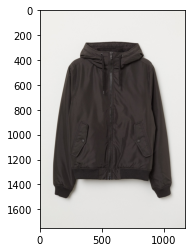

most similar products:
[176209040, 456163090, 437783003, 176209046, 469682004]
176209023
['Hoodie' 'Hoodie' 'Hoodie' 'Hoodie' 'Cardigan']
['Hoodie']
80.0
{'176209023': 80.0}


In [90]:
cust_id='00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657'
index_pos=test_data[test_data['customer_id']==cust_id].index.values
arts=test_data.iloc[index_pos[0],1]
print(arts)
products=[]
items=[]
for a in arts:
    art_index=articles[articles.article_id==a].index.values
    products.append(articles.at[art_index[0],'product_type_name'])
    items.append(a)
print(items)
unique_items=pd.DataFrame()
unique_items['products']=pd.Series(products)
unique_items['article_ids']=pd.Series(items)
unique_products=unique_items.groupby('products')['article_ids'].agg(list).reset_index()
print(unique_products.head())
final_list=[]
for i,j in zip(unique_products['products'],unique_products['article_ids']):
    arts_list=[]
    for x in j:
        arts_list.append(str(x))
    final_list.append(arts_list[0])
print(final_list)
for ids in final_list:
    idd = ids
    try:
        retrieve_most_similar_products1(idd)
    except:
        print('iamge not there')